# Twitter Sentiment Analysis


Dans ce notebook, je présente une modélisation simple de l'analyse du sentiment d'une base de données de tweets liés à des entreprises spécifiques. Cette étude est structurée comme suit :

1 - Exploration initiale des données\
2 - Nettoyage des données\
3 - Modèle de Random Forest\
4 - Modèle de régression logistique\
5 - Modèle de SVM

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import seaborn as sns

In [10]:
column_names=['Tweet_ID','Entity','Sentiment','Tweet_content']

train=pd.read_csv("twitter_training.csv", sep=',',names=column_names)

# Exploratory data analysis

## Sentiment

In [11]:
print("Nombre d'entités unique : "+str(len(train.Entity.unique())))
entities = train.Entity.value_counts().to_frame()

Nombre d'entités unique : 32


In [12]:
sentiment = train.Sentiment.value_counts().to_frame().T
sentiment

,Negative,Positive,Neutral,Irrelevant
Sentiment,22542,20832,18318,12990


<ipython-input-13-9860849a0998>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Sentiment', data=train, palette='muted')


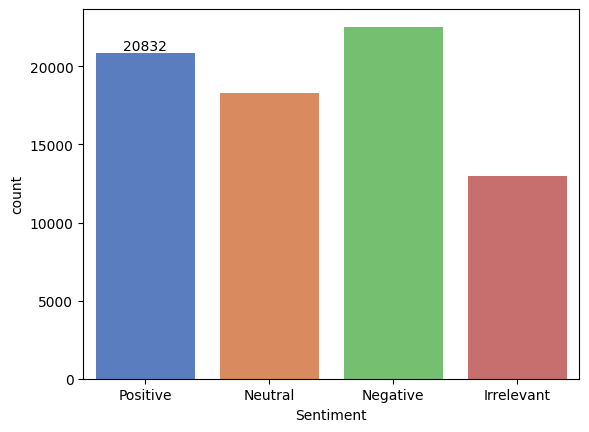

In [13]:
ax = sns.countplot(x='Sentiment', data=train, palette='muted')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

In [14]:
pd.crosstab(train.Sentiment , train.Entity).T.style.background_gradient( subset=['Negative'],cmap='Reds')\
.background_gradient(subset=['Positive'] , cmap='Greens')\
.background_gradient(subset=['Irrelevant'] , cmap='Purples')\
.background_gradient(subset=['Neutral'] , cmap='Greys')

Sentiment,Irrelevant,Negative,Neutral,Positive
Entity,,,,
Amazon,192,576,1236,312
ApexLegends,192,600,942,642
AssassinsCreed,264,378,156,1446
Battlefield,918,474,360,594
Borderlands,240,426,600,1020
CS-GO,636,348,552,768
CallOfDuty,672,894,378,450
CallOfDutyBlackopsColdWar,576,576,360,864
Cyberpunk2077,480,390,468,966


# Data cleaning

In [15]:
# Valeurs manquantes
train.isna().sum()

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64

In [16]:
# Valeurs dupliquées
train.duplicated().sum()

2700

In [17]:
# Suppression des lignes en doubles et des lignes avec valeurs manquantes
train.dropna(inplace=True)
train.drop_duplicates(inplace=True)

In [18]:
import re

# on met tout en minuscule, on vire les emojis et les urls
def supr_emojis(texte):
    # Expression régulière pour détecter les emojis Unicode
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emojis visages
                               u"\U0001F300-\U0001F5FF"  # Autres emojis symboles et pictogrammes
                               u"\U0001F680-\U0001F6FF"  # Emojis transports et symboles
                               u"\U0001F700-\U0001F77F"  # Emojis alchimiques
                               u"\U0001F780-\U0001F7FF"  # Emojis jeux de cartes
                               u"\U0001F800-\U0001F8FF"  # Emojis symboles géométriques
                               u"\U0001F900-\U0001F9FF"  # Emojis symboles supplémentaires
                               u"\U0001FA00-\U0001FA6F"  # Emojis personnages
                               u"\U0001FA70-\U0001FAFF"  # Emojis personnages
                               u"\U00002702-\U000027B0"  # Emojis autres symboles
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    texte_sans_emojis = emoji_pattern.sub(r'', texte)
    return texte_sans_emojis

def supr_urls(texte):
    # Expression régulière pour détecter les URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    texte_sans_urls = url_pattern.sub('', texte)
    return texte_sans_urls

def texte_en_minuscule(texte):
    texte_minuscule = texte.lower()
    return texte_minuscule

In [19]:
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: supr_emojis(x))
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: supr_urls(x))
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: texte_en_minuscule(x))

# Tokenization et Lemmatisation

La tokenization consiste à diviser un texte en unités discrètes appelées "tokens", qui peuvent être des mots, des phrases, des caractères, ou d'autres éléments en fonction du niveau de granularité souhaité.
La tokenization est une étape cruciale car elle permet de représenter le texte sous une forme numérique compréhensible par les algorithmes de machine learning.\
La lemmatisation est le processus de réduction des mots à leur forme canonique ou "lemme". Le lemme d'un mot est sa forme de base, qui représente le mot dans un dictionnaire. Par exemple, les mots "mange", "manger" et "mangé" peuvent être tous réduits à leur lemme "manger". Cette normalisation aide à réduire la complexité des données textuelles et à améliorer la performance des modèles de machine learning en traitant les mots de manière uniforme.

In [20]:
import spacy

In [21]:
#tokenisation lemmatisation
nlp=spacy.load('en_core_web_sm')

def preprocess(text):
    # Analyser le texte avec le modèle spacy
    doc = nlp(text)

    # Filtrer les tokens qui ne sont pas des stop words ni de la ponctuation, et les lemmatiser
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    # Joindre les tokens filtrés en une seule chaîne de caractères
    preprocessed_text = " ".join(filtered_tokens)

    return preprocessed_text

train['preprocessed_text']=train['Tweet_content'].apply(lambda x: preprocess(x))

In [22]:
k = np.random.randint(200)
print(train['preprocessed_text'][k])
print(train['Tweet_content'][k])

borderland fucking thrash
all the borderlands are fucking thrash


# Machine Learning

## Train Test Split

In [23]:
from sklearn.model_selection import train_test_split

X_train ,X_test , y_train, y_test = train_test_split(
    train[['preprocessed_text']],
    train[['Sentiment']],
    test_size=0.2,
    random_state=42
)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer()

X_train_vect= vectorizer.fit_transform(X_train['preprocessed_text'])
X_test_vect= vectorizer.transform(X_test['preprocessed_text'])

y_train=y_train['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})
y_test=y_test['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})

## Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [26]:
model = RandomForestClassifier()
model.fit(X_train_vect,y_train)

y_predict= model.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3877
           1       0.93      0.93      0.93      4383
           2       0.94      0.89      0.91      3543
           3       0.97      0.85      0.90      2529

    accuracy                           0.91     14332
   macro avg       0.92      0.90      0.91     14332
weighted avg       0.91      0.91      0.91     14332



## Logisitic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [28]:
model2 = LogisticRegression(C=1, solver="liblinear",max_iter=200)
model2.fit(X_train_vect, y_train)

y_predict = model2.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      3877
           1       0.74      0.85      0.79      4383
           2       0.78      0.71      0.74      3543
           3       0.82      0.62      0.70      2529

    accuracy                           0.76     14332
   macro avg       0.77      0.74      0.75     14332
weighted avg       0.76      0.76      0.75     14332



## SVM

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [30]:
model3 = SVC(C=1, kernel='linear')
model2.fit(X_train_vect, y_train)

y_predict = model2.predict(X_test_vect)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      3877
           1       0.74      0.85      0.79      4383
           2       0.78      0.71      0.74      3543
           3       0.82      0.62      0.70      2529

    accuracy                           0.76     14332
   macro avg       0.77      0.74      0.75     14332
weighted avg       0.76      0.76      0.75     14332



## Analyse des performances des modèles pour la classification des sentiments des tweets

### Random Forest :
- Performances exceptionnelles
  - Capacité à gérer les caractéristiques non linéaires et les interactions complexes entre les variables
  - Composition d'ensembles d'arbres de décision pour capturer efficacement les relations entre les mots et les phrases
- Réduction du risque de surapprentissage grâce à l'ensemble de modèles

### Régression Logistique :
- Performances relativement inférieures
  - Limitations dues à sa nature linéaire
  - Moins adaptée pour capturer les subtilités et les nuances des données textuelles

### SVM (Machine à Vecteurs de Support) :
- Performances légèrement inférieures au Random Forest
  - Sensibilité aux paramètres du modèle, nécessitant un ajustement précis
  - Capacité à gérer des données non linéaires grâce à l'utilisation de fonctions de noyau

## Conclusion :
Le choix du modèle dépend de l'équilibre entre complexité, capacité de généralisation et performances prédictives. Dans ce cas, le Random Forest se distingue comme le choix optimal, offrant une combinaison de flexibilité et de robustesse pour la classification des sentiments des tweets.
